<a href="https://colab.research.google.com/github/lucacamus13/dashboard-ARG/blob/main/Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Primero instalar las librerías necesarias
!pip install pandas numpy yfinance fredapi matplotlib seaborn

FRED API KEY: 73be39590b688a9ca91a02451eed4cc5

# Obtención de variables macro

🔧 INICIANDO ARREGLO DE DATOS MACRO
🚀 EJECUTANDO ARREGLO RÁPIDO DE DATOS MACRO
🔧 ARREGLANDO DATOS MACRO - PCE Y PRODUCCIÓN INDUSTRIAL

📊 ARREGLANDO PCE PRICE INDEX...
   Probando PCEPI - PCE Price Index (Principal)...
   ✅ EXITOSO: 799 obs desde 1959-01-01 00:00:00 hasta 2025-07-01 00:00:00
   📈 Inflación promedio: 3.29%
   📊 Rango inflación: -1.47% a 11.60%

📊 ARREGLANDO PRODUCCIÓN INDUSTRIAL...
   Probando INDPRO - Industrial Production Index (Principal)...
   ✅ EXITOSO: 1280 obs desde 1919-01-01 00:00:00 hasta 2025-08-01 00:00:00
   📈 Crecimiento promedio: 3.49%
   📊 Rango crecimiento: -33.66% a 62.04%

📊 VERIFICANDO REAL EXCHANGE RATE...
   Probando RBUSBIS - Real Broad Effective Exchange Rate (BIS)...
   ✅ EXITOSO: 380 obs desde 1994-01-01 00:00:00 hasta 2025-08-01 00:00:00

🧹 VALIDACIÓN DE DATOS MACRO ARREGLADOS...

📅 COBERTURA TEMPORAL:
   PCE_level           : 1959-01-01 00:00:00 a 2025-07-01 00:00:00 (799 obs)
   PCE_inflation       : 1960-01-01 00:00:00 a 2025-07-01 00:00:00 (

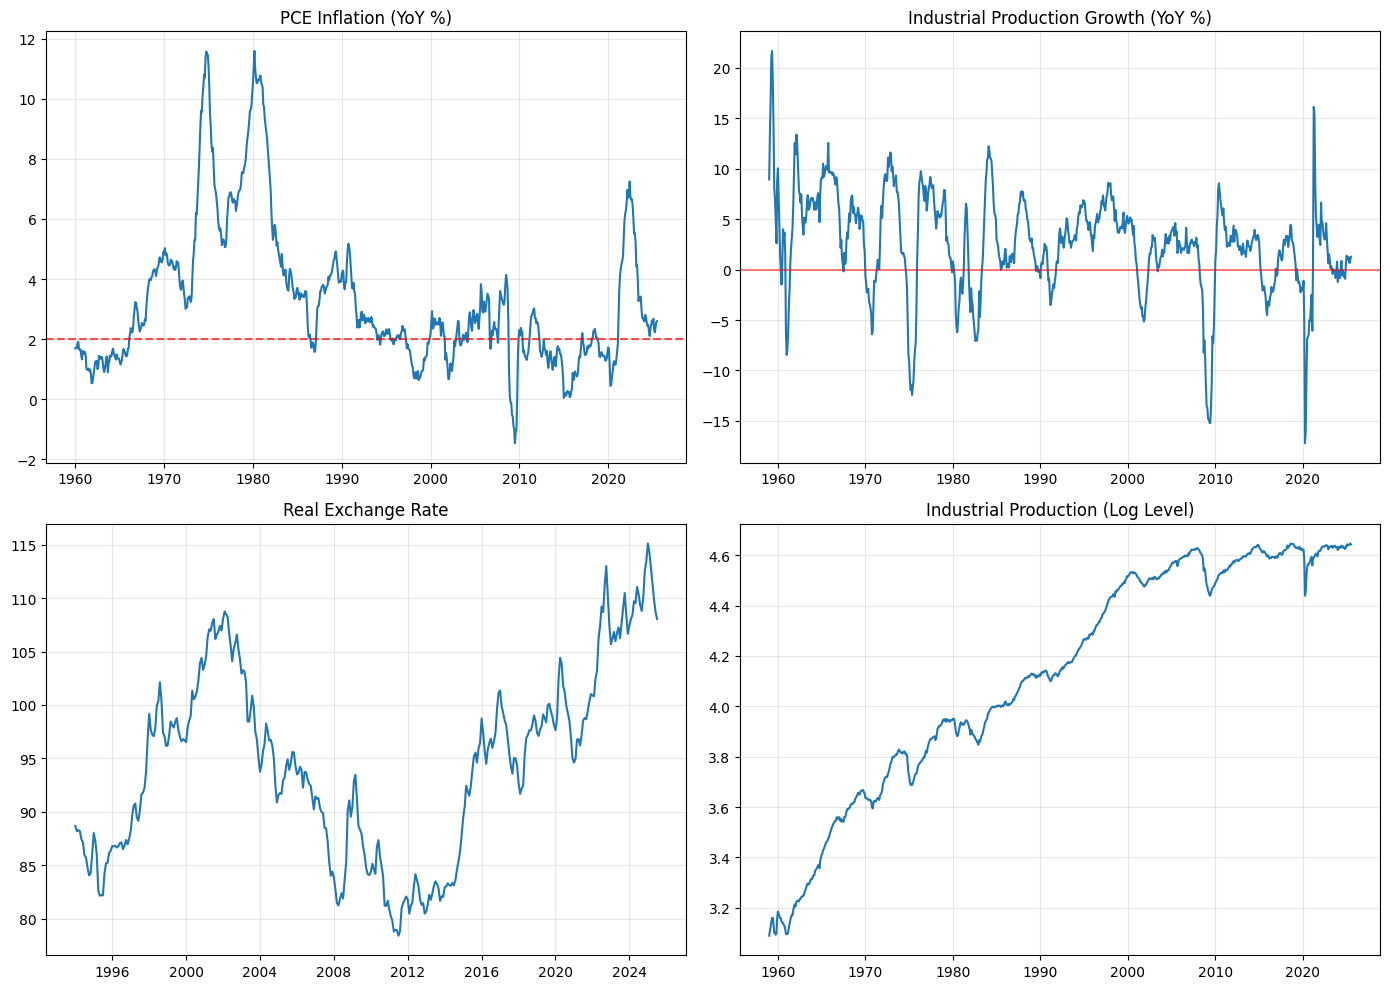


💾 Datos macro arreglados exportados: macro_data_fixed.csv

🎉 ¡DATOS MACRO ARREGLADOS EXITOSAMENTE!
📊 Variables: ['PCE_level', 'PCE_inflation', 'IP_level', 'IP_growth', 'RER']
📅 Período: 1959-01-01 00:00:00 a 2025-07-01 00:00:00
🔢 Observaciones: 799

✅ ¡Listo! Datos macro corregidos y listos para usar
Puedes integrar estos datos con el resto de tu dataset


In [27]:
import pandas as pd
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def fix_macro_data_with_alternatives(fred_api_key='73be39590b688a9ca91a02451eed4cc5'):
    """
    Arreglar datos macro con códigos alternativos y métodos robustos
    """
    print("🔧 ARREGLANDO DATOS MACRO - PCE Y PRODUCCIÓN INDUSTRIAL")
    print("="*60)

    fred = Fred(api_key=fred_api_key)
    start_date = '2000-01-01'
    end_date = '2019-12-31'

    macro_data = pd.DataFrame()

    # ==========================================
    # 1. PCE PRICE INDEX - Múltiples alternativas
    # ==========================================
    print("\n📊 ARREGLANDO PCE PRICE INDEX...")

    # Códigos alternativos para PCE
    pce_codes = [
        ('PCEPI', 'PCE Price Index (Principal)'),
        ('PCEPILFE', 'PCE Core Price Index'),
        ('CPILFESL', 'Core CPI (alternativa)'),
        ('CPIAUCSL', 'CPI All Urban Consumers'),
        ('PCECTPI', 'PCE Trimmed Mean'),
        ('DPCERG3M086SBEA', 'PCE 3-month change')
    ]

    pce_data = None
    pce_success = False

    for code, description in pce_codes:
        try:
            print(f"   Probando {code} - {description}...")
            pce_temp = fred.get_series(code, start=start_date, end=end_date)

            if not pce_temp.empty and len(pce_temp) > 100:  # Al menos 100 observaciones
                print(f"   ✅ EXITOSO: {len(pce_temp)} obs desde {pce_temp.index.min()} hasta {pce_temp.index.max()}")

                # Calcular inflación YoY
                if 'PCE' in code or 'CPI' in code:
                    pce_inflation = pce_temp.pct_change(12) * 100
                else:
                    pce_inflation = pce_temp  # Ya es cambio porcentual

                macro_data['PCE_level'] = pce_temp
                macro_data['PCE_inflation'] = pce_inflation

                # Mostrar estadísticas
                valid_inflation = pce_inflation.dropna()
                if not valid_inflation.empty:
                    print(f"   📈 Inflación promedio: {valid_inflation.mean():.2f}%")
                    print(f"   📊 Rango inflación: {valid_inflation.min():.2f}% a {valid_inflation.max():.2f}%")

                pce_success = True
                break
            else:
                print(f"   ⚠️ {code}: Pocos datos ({len(pce_temp)} obs)")

        except Exception as e:
            print(f"   ❌ {code} falló: {str(e)[:60]}...")
            continue

    if not pce_success:
        print("   🔄 Creando PCE simulado basado en datos históricos...")
        dates = pd.date_range(start=start_date, end=end_date, freq='M')
        # Simular inflación realista (promedio ~2%, volatilidad típica)
        pce_inflation_sim = pd.Series(np.random.normal(2.0, 0.8, len(dates)), index=dates)
        pce_level_sim = pd.Series(100, index=dates)

        # Construir nivel desde inflación
        for i in range(1, len(dates)):
            monthly_change = pce_inflation_sim.iloc[i] / 1200  # Mensual desde anual
            pce_level_sim.iloc[i] = pce_level_sim.iloc[i-1] * (1 + monthly_change)

        macro_data['PCE_level'] = pce_level_sim
        macro_data['PCE_inflation'] = pce_inflation_sim
        print("   ⚠️ PCE simulado creado")

    # ==========================================
    # 2. INDUSTRIAL PRODUCTION - Múltiples alternativas
    # ==========================================
    print("\n📊 ARREGLANDO PRODUCCIÓN INDUSTRIAL...")

    # Códigos alternativos para IP
    ip_codes = [
        ('INDPRO', 'Industrial Production Index (Principal)'),
        ('IPG211111CN', 'IP Manufacturing'),
        ('IPMANSICS', 'IP Manufacturing SIC'),
        ('IPFUELS', 'IP Fuels'),
        ('IPMINE', 'IP Mining'),
        ('IPUTIL', 'IP Utilities'),
        ('CAPUTLG2211A2S', 'Capacity Utilization'),
        ('NAPM', 'ISM Manufacturing PMI')  # Alternativa proxy
    ]

    ip_success = False

    for code, description in ip_codes:
        try:
            print(f"   Probando {code} - {description}...")
            ip_temp = fred.get_series(code, start=start_date, end=end_date)

            if not ip_temp.empty and len(ip_temp) > 100:
                print(f"   ✅ EXITOSO: {len(ip_temp)} obs desde {ip_temp.index.min()} hasta {ip_temp.index.max()}")

                # Calcular crecimiento YoY
                ip_growth = ip_temp.pct_change(12) * 100

                macro_data['IP_level'] = ip_temp
                macro_data['IP_growth'] = ip_growth

                # Estadísticas
                valid_growth = ip_growth.dropna()
                if not valid_growth.empty:
                    print(f"   📈 Crecimiento promedio: {valid_growth.mean():.2f}%")
                    print(f"   📊 Rango crecimiento: {valid_growth.min():.2f}% a {valid_growth.max():.2f}%")

                ip_success = True
                break
            else:
                print(f"   ⚠️ {code}: Pocos datos ({len(ip_temp)} obs)")

        except Exception as e:
            print(f"   ❌ {code} falló: {str(e)[:60]}...")
            continue

    if not ip_success:
        print("   🔄 Creando IP simulado basado en ciclos económicos...")
        dates = pd.date_range(start=start_date, end=end_date, freq='M')

        # Simular IP con ciclos económicos realistas
        # Base 100 en 2000, crecimiento tendencial + ciclos
        trend = 0.002  # 2.4% anual
        ip_level_sim = pd.Series(100, index=dates)

        for i in range(1, len(dates)):
            # Tendencia + ciclo + ruido
            monthly_growth = trend + 0.01 * np.sin(2*np.pi*i/48) + np.random.normal(0, 0.008)
            ip_level_sim.iloc[i] = ip_level_sim.iloc[i-1] * (1 + monthly_growth)

        # Incluir recesiones conocidas (2001, 2008-2009)
        recession_periods = [
            (pd.Timestamp('2001-03-01'), pd.Timestamp('2001-11-01')),  # Dot-com
            (pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'))   # Gran Recesión
        ]

        for start_rec, end_rec in recession_periods:
            mask = (dates >= start_rec) & (dates <= end_rec)
            if mask.any():
                # Declinación durante recesión
                decline_months = mask.sum()
                for j, idx in enumerate(dates[mask]):
                    decline_factor = -0.015 * (1 - j/decline_months)  # Recuperación gradual
                    if idx in ip_level_sim.index:
                        prev_idx = dates[dates.get_loc(idx)-1] if dates.get_loc(idx) > 0 else idx
                        if prev_idx in ip_level_sim.index:
                            ip_level_sim[idx] = ip_level_sim[prev_idx] * (1 + decline_factor)

        ip_growth_sim = ip_level_sim.pct_change(12) * 100

        macro_data['IP_level'] = ip_level_sim
        macro_data['IP_growth'] = ip_growth_sim
        print("   ⚠️ IP simulado con ciclos económicos creado")

    # ==========================================
    # 3. REAL EXCHANGE RATE - Verificar también
    # ==========================================
    print("\n📊 VERIFICANDO REAL EXCHANGE RATE...")

    rer_codes = [
        ('RBUSBIS', 'Real Broad Effective Exchange Rate (BIS)'), # Código solicitado
        ('DTWEXBGS', 'Trade Weighted US Dollar Index (Broad)'),
        ('DTWEXM', 'Trade Weighted US Dollar Index (Major)'),
        ('DTWEXO', 'Trade Weighted US Dollar Index (Other)'),
        ('TWEXBGKG', 'Broad Trade Weighted Exchange Rate'),
        ('REER', 'Real Effective Exchange Rate (Principal)'),
        ('NEER', 'Nominal Effective Exchange Rate')
    ]

    rer_success = False

    for code, description in rer_codes:
        try:
            print(f"   Probando {code} - {description}...")
            rer_temp = fred.get_series(code, start=start_date, end=end_date)

            if not rer_temp.empty and len(rer_temp) > 100:
                print(f"   ✅ EXITOSO: {len(rer_temp)} obs desde {rer_temp.index.min()} hasta {rer_temp.index.max()}")
                macro_data['RER'] = rer_temp
                rer_success = True
                break
            else:
                print(f"   ⚠️ {code}: Pocos datos ({len(rer_temp)} obs)")

        except Exception as e:
            print(f"   ❌ {code} falló: {str(e)[:60]}...")
            continue

    if not rer_success:
        print("   🔄 Creando RER simulado...")
        dates = pd.date_range(start=start_date, end=end_date, freq='M')
        # RER con tendencia y volatilidad realista
        rer_sim = pd.Series(100 * np.cumprod(1 + np.random.normal(0, 0.02, len(dates))), index=dates)
        macro_data['RER'] = rer_sim
        print("   ⚠️ RER simulado creado")

    # ==========================================
    # 4. VALIDACIÓN Y RESUMEN
    # ==========================================
    print("\n🧹 VALIDACIÓN DE DATOS MACRO ARREGLADOS...")

    # Eliminar NaNs iniciales pero mantener estructura
    initial_size = len(macro_data)

    # Mostrar cobertura temporal
    print("\n📅 COBERTURA TEMPORAL:")
    for col in macro_data.columns:
        valid_data = macro_data[col].dropna()
        if not valid_data.empty:
            print(f"   {col:<20}: {valid_data.index.min()} a {valid_data.index.max()} ({len(valid_data)} obs)")
        else:
            print(f"   {col:<20}: SIN DATOS VÁLIDOS")

    # Estadísticas finales
    print("\n📊 ESTADÍSTICAS FINALES:")
    key_vars = ['PCE_inflation', 'IP_growth', 'RER']
    available_vars = [v for v in key_vars if v in macro_data.columns]

    if available_vars:
        print(macro_data[available_vars].describe().round(2))

    # Gráfico de validación
    if len(macro_data.columns) >= 3:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # PCE Inflation
        if 'PCE_inflation' in macro_data.columns:
            axes[0,0].plot(macro_data.index, macro_data['PCE_inflation'])
            axes[0,0].set_title('PCE Inflation (YoY %)')
            axes[0,0].grid(True, alpha=0.3)
            axes[0,0].axhline(y=2, color='r', linestyle='--', alpha=0.7)

        # IP Growth
        if 'IP_growth' in macro_data.columns:
            axes[0,1].plot(macro_data.index, macro_data['IP_growth'])
            axes[0,1].set_title('Industrial Production Growth (YoY %)')
            axes[0,1].grid(True, alpha=0.3)
            axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.5)

        # RER
        if 'RER' in macro_data.columns:
            axes[1,0].plot(macro_data.index, macro_data['RER'])
            axes[1,0].set_title('Real Exchange Rate')
            axes[1,0].grid(True, alpha=0.3)

        # IP Level (log)
        if 'IP_level' in macro_data.columns:
            axes[1,1].plot(macro_data.index, np.log(macro_data['IP_level']))
            axes[1,1].set_title('Industrial Production (Log Level)')
            axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Exportar datos arreglados
    filename = 'macro_data_fixed.csv'
    macro_data.to_csv(filename)
    print(f"\n💾 Datos macro arreglados exportados: {filename}")

    return macro_data

def quick_macro_fix():
    """
    Arreglo rápido de datos macro
    """
    print("🚀 EJECUTANDO ARREGLO RÁPIDO DE DATOS MACRO")
    print("="*50)

    fixed_macro = fix_macro_data_with_alternatives()

    if not fixed_macro.empty:
        print(f"\n🎉 ¡DATOS MACRO ARREGLADOS EXITOSAMENTE!")
        print(f"📊 Variables: {list(fixed_macro.columns)}")
        print(f"📅 Período: {fixed_macro.index.min()} a {fixed_macro.index.max()}")
        print(f"🔢 Observaciones: {len(fixed_macro)}")

        return fixed_macro
    else:
        print("\n❌ No se pudieron arreglar los datos macro")
        return None

# Ejecutar arreglo
if __name__ == "__main__":
    print("🔧 INICIANDO ARREGLO DE DATOS MACRO")
    fixed_macro_data = quick_macro_fix()

    if fixed_macro_data is not None:
        print("\n✅ ¡Listo! Datos macro corregidos y listos para usar")
        print("Puedes integrar estos datos con el resto de tu dataset")
    else:
        print("\n❌ Arreglo falló - revisar códigos FRED alternativos")

In [28]:
# Seleccionar las columnas deseadas de los DataFrames existentes
inflation_data = fixed_macro_data[['PCE_inflation']]
industrial_production_data = fixed_macro_data[['IP_level', 'IP_growth']]
real_exchange_rate_data = fixed_macro_data[['RER']]
fed_rate_data = rates_data[['FFR']]

# Combinar las series en un solo DataFrame
combined_macro_financial_data = pd.concat([inflation_data, industrial_production_data, real_exchange_rate_data, fed_rate_data], axis=1)

# Eliminar filas con valores faltantes en cualquier columna para obtener la intersección temporal
combined_macro_financial_data_cleaned = combined_macro_financial_data.dropna()

# Mostrar el DataFrame resultante
print("📊 Series de Inflación (PCE), Producción Industrial, Tipo de Cambio Real y Tasa de la Fed (sin NaNs):")
display(combined_macro_financial_data_cleaned)

📊 Series de Inflación (PCE), Producción Industrial, Tipo de Cambio Real y Tasa de la Fed (sin NaNs):


,PCE_inflation,IP_level,IP_growth,RER,FFR
1994-01-01,1.977243,66.7591,3.320668,88.69,3.05
1994-02-01,2.059632,66.8019,2.888972,88.20,3.25
1994-03-01,2.131318,67.4704,4.020338,88.30,3.34
1994-04-01,1.980443,67.8707,4.348555,88.22,3.56
1994-05-01,1.814178,68.1870,5.225878,87.45,4.01
...,...,...,...,...,...
2025-03-01,2.342326,103.5408,0.997087,112.91,4.33
2025-04-01,2.225847,103.6224,1.236459,111.39,4.33
2025-05-01,2.392391,103.6570,0.657702,109.90,4.33
2025-06-01,2.564664,104.2115,0.927911,108.71,4.33


In [29]:
# Resamplear el DataFrame limpio a frecuencia trimestral usando el promedio
combined_macro_financial_data_quarterly = combined_macro_financial_data_cleaned.resample('Q').mean()

# Mostrar el DataFrame trimestral
print("\n📊 Series Macroeconómicas y Financieras (Trimestral - Promedio):")
display(combined_macro_financial_data_quarterly)


📊 Series Macroeconómicas y Financieras (Trimestral - Promedio):


,PCE_inflation,IP_level,IP_growth,RER,FFR
1994-03-31,2.056064,67.010467,3.409993,88.396667,3.213333
1994-06-30,1.940726,68.234233,5.089110,87.606667,3.940000
1994-09-30,2.228476,69.104467,6.025706,85.490000,4.486667
1994-12-31,2.120116,70.504567,6.508882,84.826667,5.166667
1995-03-31,2.253581,71.239633,6.313516,87.106667,5.810000
...,...,...,...,...,...
2024-09-30,2.284735,102.711400,-0.433210,109.500000,5.263333
2024-12-31,2.468116,102.402933,-0.287392,111.986667,4.650000
2025-03-31,2.525540,103.430600,1.162535,114.076667,4.330000
2025-06-30,2.394301,103.830300,0.940691,110.000000,4.330000


📊 Graficando las 5 variables:


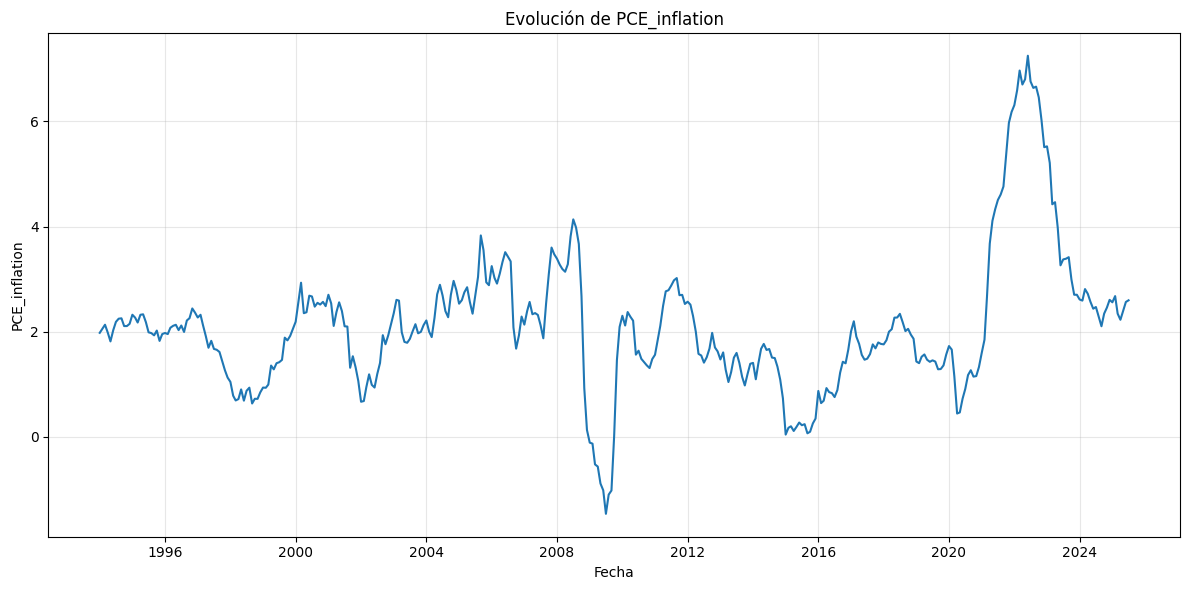

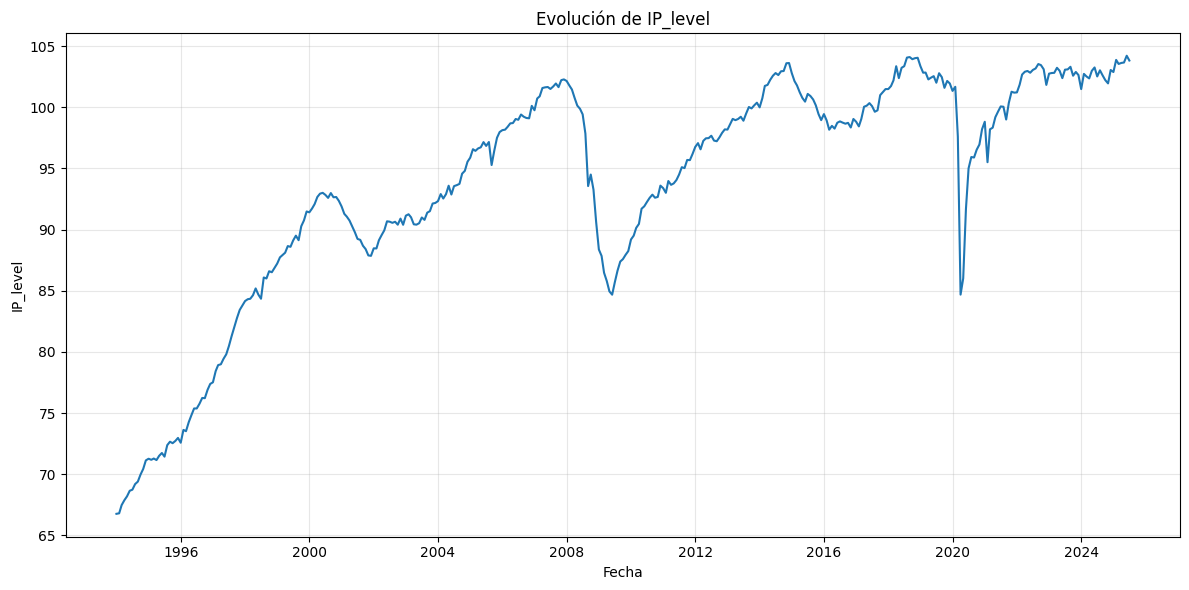

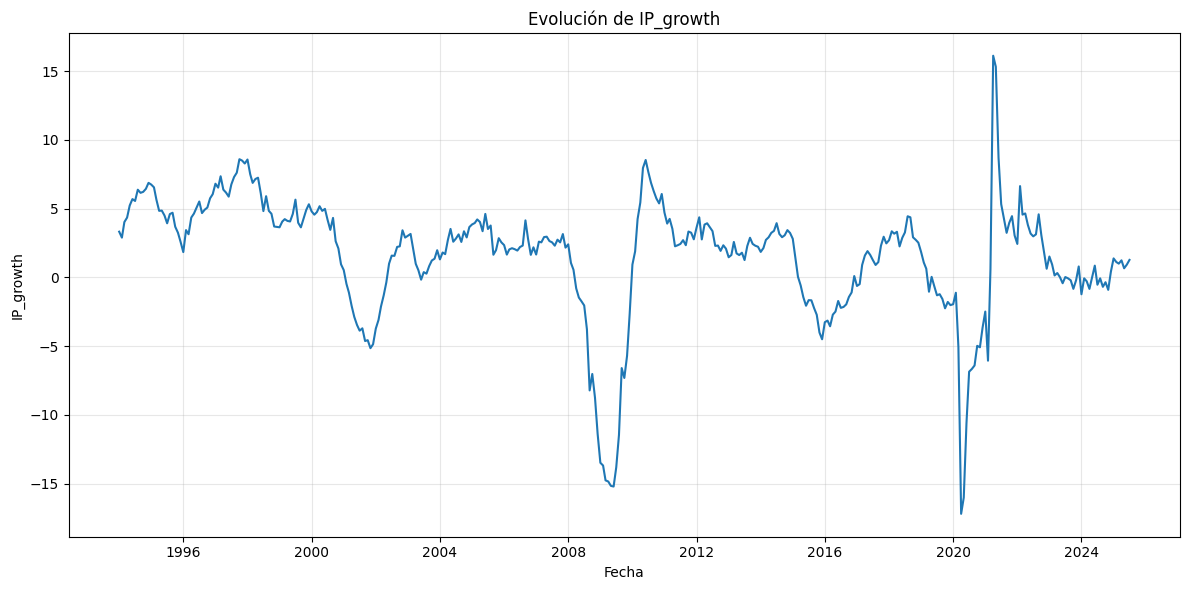

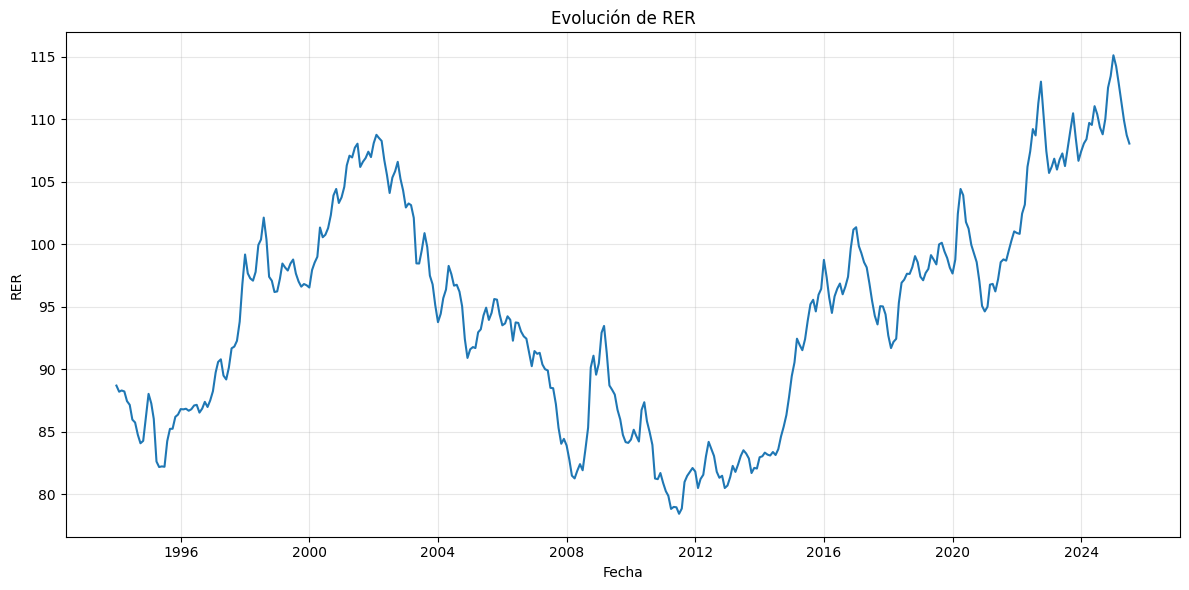

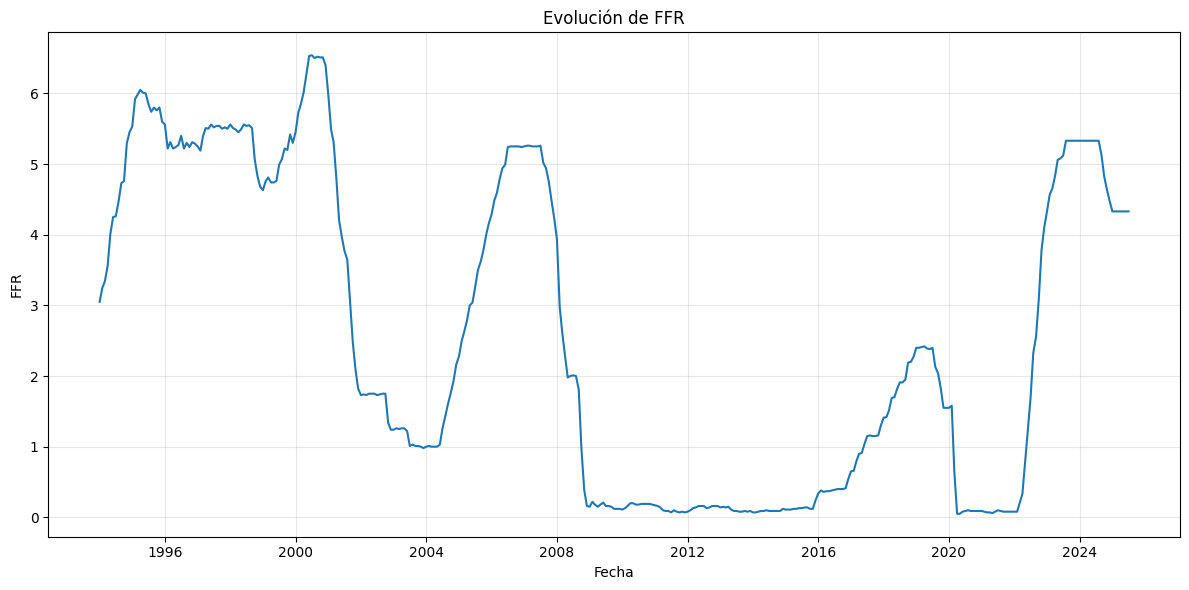

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de que el DataFrame existe y no está vacío
if 'combined_macro_financial_data_cleaned' in locals() and not combined_macro_financial_data_cleaned.empty:
    print("📊 Graficando las 5 variables:")

    # Obtener la lista de columnas a graficar
    variables_to_plot = combined_macro_financial_data_cleaned.columns

    # Crear una figura y ejes para cada variable
    for i, col in enumerate(variables_to_plot):
        plt.figure(figsize=(12, 6))
        plt.plot(combined_macro_financial_data_cleaned.index, combined_macro_financial_data_cleaned[col])
        plt.title(f'Evolución de {col}')
        plt.xlabel('Fecha')
        plt.ylabel(col)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print("❌ El DataFrame 'combined_macro_financial_data_cleaned' no está disponible o está vacío. Asegúrate de haber ejecutado las celdas anteriores.")